In [1]:
import pandas as pd

In [2]:
empluzz = pd.read_csv("Unemployment2023.csv")

empluzz = empluzz[(empluzz["Attribute"] == "Median_Household_Income_2022") & (empluzz["Area_Name"].str.contains("County"))]
empluzz.rename(columns={"FIPS_Code": "LocationID", "Value": "Median_Household_Income_2022"}, inplace=True)
empluzz["LocationID"] = empluzz["LocationID"].astype(str)

empluzz = empluzz[["LocationID", "Median_Household_Income_2022"]]
print(empluzz.head())

    LocationID  Median_Household_Income_2022
294       1001                       70148.0
395       1003                       71704.0
496       1005                       41151.0
597       1007                       54309.0
698       1009                       60553.0


In [ ]:
census = pd.read_csv("cc-est2024-alldata.csv", encoding="latin-1")

census = census[(census["YEAR"] == 4) & census["AGEGRP"] == 0]

census["LocationID"] = census["STATE"].astype(str).str.zfill(2) + census["COUNTY"].astype(str).str.zfill(3)

census["Pct_Black"] = census["BA_MALE"] + census["BA_FEMALE"]
census["Pct_Hispanic"] = census["H_MALE"] + census["H_FEMALE"]
census["Pct_White"] = census["WA_MALE"] + census["WA_FEMALE"]
census["Pct_Asian"] = census["AA_MALE"] + census["AA_FEMALE"]

census["Pct_Black"] = census["Pct_Black"] / census["TOT_POP"] 
census["Pct_Hispanic"] = census["Pct_Hispanic"] / census["TOT_POP"]
census["Pct_White"] = census["Pct_White"] / census["TOT_POP"]
census["Pct_Asian"] = census["Pct_Asian"] / census["TOT_POP"]

census["LocationID"] = census["LocationID"].astype(str)

census = census[["LocationID", "Pct_Black", "Pct_Hispanic", "Pct_Asian", "Pct_White"]]

In [ ]:
df = pd.read_csv("PLACES__Local_Data_for_Better_Health__County_Data_2022_release.csv", engine="python")
df.describe()

,Year,Data_Value,Low_Confidence_Limit,High_Confidence_Limit,TotalPopulation,TotalPop18plus,LocationID
count,240886.000000,240886.000000,240886.000000,240886.000000,2.408860e+05,2.408860e+05,240886.000000
mean,2021.897777,25.793842,23.213787,28.436679,2.162907e+05,1.692237e+05,30372.252360
std,0.302941,21.806707,20.516978,23.057834,6.079978e+06,4.758322e+06,15112.488466
min,2021.000000,1.700000,1.500000,1.800000,5.100000e+01,3.700000e+01,59.000000
25%,2022.000000,9.800000,8.700000,11.000000,1.076900e+04,8.398000e+03,19021.000000
50%,2022.000000,17.700000,15.500000,20.100000,2.594000e+04,2.045900e+04,29161.000000
75%,2022.000000,33.900000,29.400000,38.500000,6.882600e+04,5.368600e+04,45077.000000
max,2022.000000,91.600000,90.000000,93.100000,3.332876e+08,2.608367e+08,56045.000000


In [5]:
df = df[df["Data_Value_Type"] == "Crude prevalence"].pivot(index=["LocationID", "LocationName"], columns="Short_Question_Text", values="Data_Value").reset_index().dropna()
df["LocationID"] = df["LocationID"].astype(str)
df = pd.merge(df, census, on="LocationID", how="inner").reset_index().dropna()

df = pd.merge(df, empluzz, on="LocationID", how="inner").reset_index().dropna()

print(df.head())


   level_0  index LocationID LocationName  All Teeth Lost  Annual Checkup  \
0        0      0      10001         Kent            13.0            78.5   
1        1      1      10001         Kent            13.0            78.5   
2        2      2      10001         Kent            13.0            78.5   
3        3      3      10001         Kent            13.0            78.5   
4        4      4      10001         Kent            13.0            78.5   

   Any Disability  Arthritis  Binge Drinking  COPD  ...  Social Isolation  \
0            28.6       28.7            14.7   7.4  ...              32.6   
1            28.6       28.7            14.7   7.4  ...              32.6   
2            28.6       28.7            14.7   7.4  ...              32.6   
3            28.6       28.7            14.7   7.4  ...              32.6   
4            28.6       28.7            14.7   7.4  ...              32.6   

   Stroke  Transportation Barriers  Utility Services Threat  \
0     3.9  

In [6]:
X = df[["Obesity", "Median_Household_Income_2022", "Pct_Black", "Pct_Hispanic", "Pct_White", "Pct_Asian"]] 
y = df["Diabetes"] / 100

X["Median_Household_Income_2022"] = X["Median_Household_Income_2022"] / 1000
X["Obesity"] = X["Obesity"] / 100

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled_array = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled_array, columns=X.columns, index=X.index)

/tmp/ipykernel_811243/107659549.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Median_Household_Income_2022"] = X["Median_Household_Income_2022"] / 1000
/tmp/ipykernel_811243/107659549.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Obesity"] = X["Obesity"] / 100


In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split


train_X, val_X, train_y, val_y = train_test_split(X_scaled, y, random_state=0)

In [8]:
model = LinearRegression()
model.fit(train_X, train_y)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [9]:
val_predictions = model.predict(val_X)
mean_absolute_error(val_y, val_predictions)

0.011969337459300214

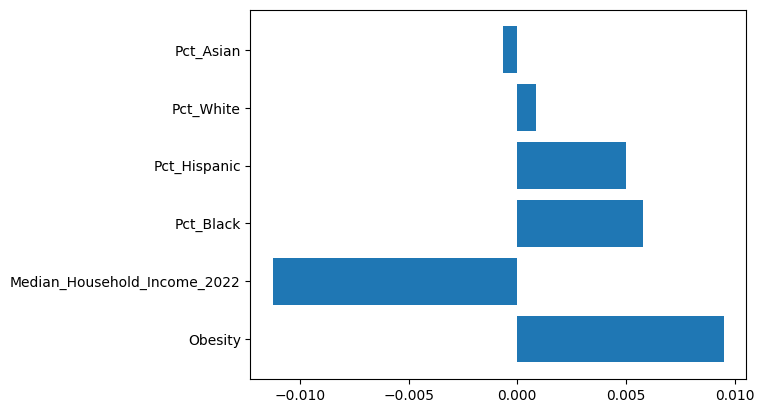

Index(['Obesity', 'Median_Household_Income_2022', 'Pct_Black', 'Pct_Hispanic',
       'Pct_White', 'Pct_Asian'],
      dtype='object') [ 0.00951116 -0.01124527  0.00577876  0.00498932  0.00085191 -0.00067231]


In [10]:
import matplotlib.pyplot as plt

features = X_scaled.columns
coef = model.coef_
plt.barh(features, coef)
plt.show()

print(features, coef)

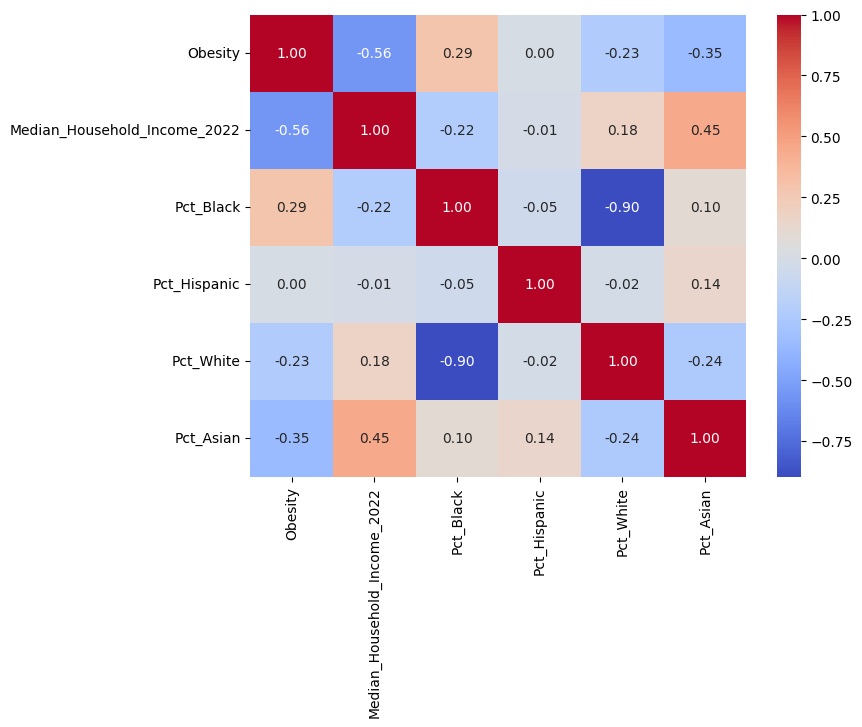

In [11]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(X_scaled.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

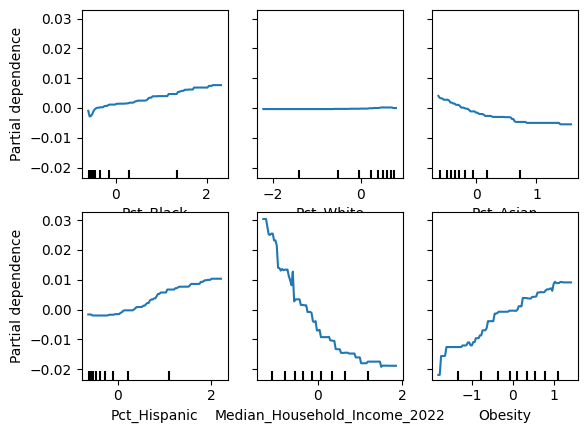

In [12]:
from sklearn.inspection import PartialDependenceDisplay
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor().fit(X_scaled, y)
PartialDependenceDisplay.from_estimator(gb_model, X_scaled, features=["Pct_Black", "Pct_White", "Pct_Asian", "Pct_Hispanic", "Median_Household_Income_2022", "Obesity"])
plt.show()

In [13]:
std_df = pd.DataFrame({"Feature": X.columns, "Standard Deviation": scaler.scale_})

print(std_df)

                        Feature  Standard Deviation
0                       Obesity            0.042199
1  Median_Household_Income_2022           15.060279
2                     Pct_Black            0.139707
3                  Pct_Hispanic            0.150102
4                     Pct_White            0.153225
5                     Pct_Asian            0.021151


In [14]:
df[["Pct_Asian", "Diabetes"]].corr()


,Pct_Asian,Diabetes
Pct_Asian,1.000000,-0.303511
Diabetes,-0.303511,1.000000


<Axes: xlabel='Pct_Hispanic', ylabel='Diabetes'>

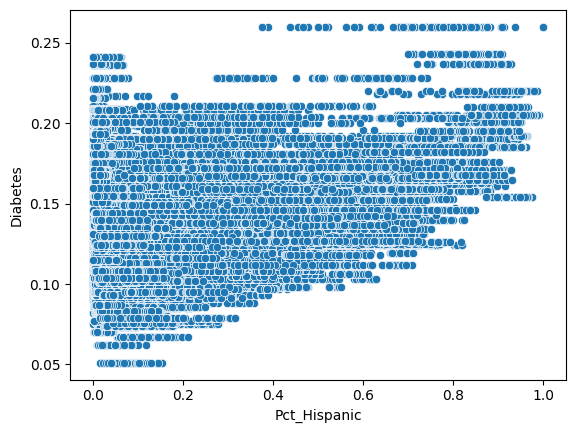

In [15]:
sns.scatterplot(x="Pct_Hispanic", y=y, data=df)

In [16]:
df[df['Median_Household_Income_2022'] > 80000][['Pct_White', 'Diabetes']].corr()

,Pct_White,Diabetes
Pct_White,1.000000,-0.126251
Diabetes,-0.126251,1.000000


In [17]:
df[(df["Median_Household_Income_2022"] > 60000) & (df["Median_Household_Income_2022"] < 79999)][["Pct_White", "Diabetes"]].corr()


,Pct_White,Diabetes
Pct_White,1.000000,-0.095003
Diabetes,-0.095003,1.000000


In [18]:
df[["Pct_Asian", "Obesity"]].corr()

,Pct_Asian,Obesity
Pct_Asian,1.00000,-0.35261
Obesity,-0.35261,1.00000


In [19]:
df[df["Pct_Asian"] > 0.2]["Annual Checkup"].mean()


np.float64(74.95738758029977)

In [20]:
df["Annual Checkup"].mean()


np.float64(76.41994646483295)

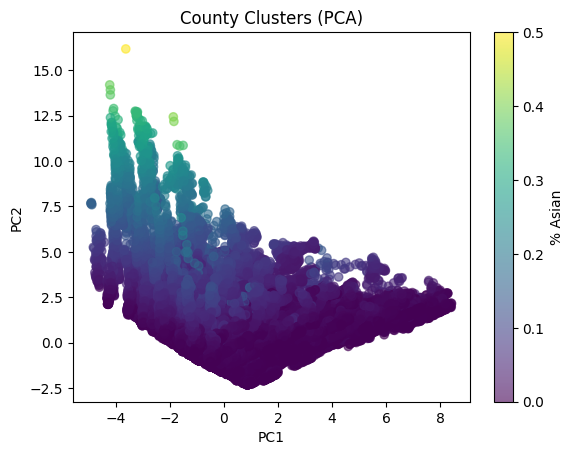

In [21]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot the PCA with color by % Asian
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['Pct_Asian'], cmap='viridis', alpha=0.6)
plt.colorbar(label='% Asian')
plt.title('County Clusters (PCA)')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.show()

In [22]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=0)
df = df.drop(columns=["index", "level_0"], errors="ignore")
df['Cluster'] = kmeans.fit_predict(X_scaled)

df.groupby('Cluster')['Pct_Asian'].mean()

cluster_means = df.groupby("Cluster").mean(numeric_only=True)

cluster_means.T

Cluster,0,1,2,3
All Teeth Lost,15.882893,10.278314,21.568981,17.017264
Annual Checkup,76.648952,75.330237,78.778967,72.400155
Any Disability,35.338186,27.626042,39.163483,38.299653
Arthritis,32.433586,26.219872,32.594136,27.075059
Binge Drinking,16.605839,17.858541,13.900122,16.424547
COPD,9.598954,6.279547,10.121913,8.154439
Cancer (non-skin) or Melanoma,9.554502,8.361072,7.755708,7.436577
Cholesterol Screening,83.278125,84.888065,84.470624,81.353494
Cognitive Disability,15.630057,12.713847,17.479185,17.765776
Colorectal Cancer Screening,64.217345,66.407773,62.563636,56.404503


Median_Household_Income_2022       -9339.628544
Colorectal Cancer Screening           -7.991749
Mammography                           -4.925160
Dental Visit                          -4.661778
Annual Checkup                        -4.519231
Arthritis                             -3.340806
Cholesterol Screening                 -2.858777
High Blood Pressure Medication        -2.196921
High Blood Pressure                   -1.788900
Cancer (non-skin) or Melanoma         -1.120517
Current Asthma                        -0.693679
Depression                            -0.560841
COPD                                  -0.512366
Pct_Black                             -0.121765
Stroke                                -0.041411
Pct_Asian                             -0.009811
Current Cigarette Smoking              0.025869
Pct_White                              0.124995
Binge Drinking                         0.303046
Coronary Heart Disease                 0.381659
Pct_Hispanic                           0

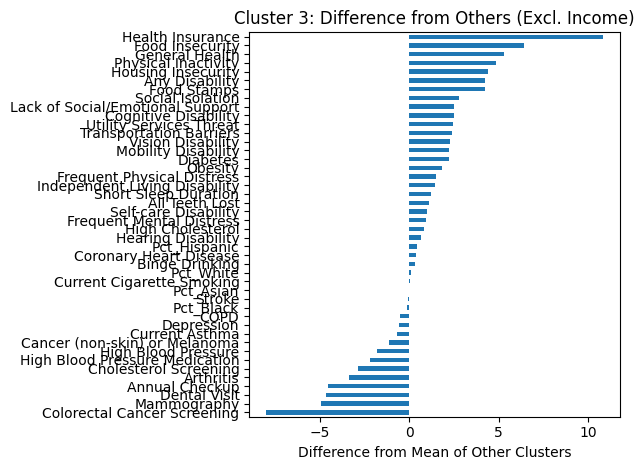

In [23]:
others_mean = cluster_means.drop(3).mean()
diff = cluster_means.loc[3] - others_mean

print(diff.sort_values())

diff_wo_income = diff.drop("Median_Household_Income_2022")

diff_wo_income.sort_values().plot(kind="barh", title="Cluster 3: Difference from Others (Excl. Income)")
plt.xlabel("Difference from Mean of Other Clusters")
plt.tight_layout()
plt.show()